# Demonstration of Knife Scans

This notebook shows the following tasks:
- basic of collecting a knife edge scan
- loading the scan data from the database
- analyzing the knife edge scan to determine beam position and size
- saving the data to disk as a csv file

First we have to import haven, the beamline control library. Haven contains most of the tools we will use. Importing it allows us to get to the functions and classes that are defined inside.

Next, the ``haven.load_instrument()`` function will read the configuration files and scan the hardware for its configuration. It will then **build the devices** that will be used for scans. This function prints out a list of motors that it has discovered.

Then, we create the run engine. The run engine is responsible for executing our scans and will be described in more detail when it is used below.

Lastly we set metadata about who is running the beamline. This value will be saved in every plan executing on this run engine. This step is optional, but will allow database queries for scans taken by a specific person.

In [1]:
import haven
# Load the motors and detectors
haven.load_instrument()
# The RunEngine will be responsible for executing the plans
RE = haven.RunEngine()
# (Optional) Save the initials of the current beamline operator as metadata
RE.md["operator"] = "MFW"  # ⇦ Put your initials in here

energy_energy
energy_mono_energy
I0_sensitivity_sens_level
Idk_sensitivity_sens_level
It_sensitivity_sens_level
SLT V Upper
SLT V Lower
SLT H Inb
SLT H Outb
KBH Down
KBH Up
KBV Down
KBV Up
KB Tbl H
KB Tbl V
Focus V
Focus H
Focus In Out
ADC KB Focus
SampleZ
I0 H
I0 V
Optic In Out
Optic V
Optic H


cannot connect to 25idcVME:m65.DESC


monochromator_horiz
monochromator_vert
monochromator_bragg
monochromator_gap
monochromator_roll2
monochromator_pitch2
monochromator_roll_int
monochromator_pi_int
monochromator_mode
monochromator_energy
Aerotech_vert
Aerotech_horiz


## Running the Scan

Running a scan in bluesky is a **two step process**.

First, **create a plan**. A plan generates messages with instructions to do things like move a motor, wait for a motor to arrive at its destination, and trigger and read a detector. To create a plan, you call a function that will generate these messages. **Calling the function doesn't actually execute the scan.** In our case, ``haven.knife_scan("Focus V", -200, 200, 50)`` will create the plan, but the plan will not do anything unless used with a run engine.

``haven.knife_scan`` needs to know which motor to scan over, so in the cell below we provide it with ``knife_motor="Focus V"``. The names of motors are the same as those printed out when loading the instrument configuration above. The *start*, *stop* parameters determine the range that the motor will scan. If *relative* is False (default), then *start* and *stop* will be absolute positions, and if *relative* is True, then *start* and *stop* will be relative to motor's position at the start of the run.

The knife scan plan also needs to know **which detectors to measure**. The names for the detectors are the same as the descriptions for the EPICS channels on the scaler. By default it will use ``It="It"`` and ``I0="I0"``, but any scaler channel can be used.

Next, **execute the plan on the run engine**. At the top of this document we created a run engine. Now we will use this run engine to execute the plan. The run engine will read the messages and perform the appropriate tasks.

When the run engine finishes the plan, it will return a unique identifier (UID). This UID is the best way to retrieve the data from the database. We will save the UID to a variable, and also print it to the page in case we want to recall it later.

In [ ]:
plan = haven.knife_scan(knife_motor="Focus V", start=-200, end=200, num=50, relative=True)
uid = RE(plan)
print(uid)

## Loading the Data

During execution the data are saved to a mongoDB database. Haven has tools to retrieve the data, as well as fit the knife scan to determine the beam position and size.

The ``load_data()`` function will return a data set, provided we supply the uid that we had previously recorded. It is possible to have multiple experimental runs within a single call to the run engine, and so our variable *uid* from above is actually a list of UIDs. Since there was only one run, we will just use the first (and only) entry: ``uid[0]``.

If the analysis is being done at a different time or place from running the scan, then the variable *uid* will probably not be set. In this case, it is possible to provide the UID that was printed above.

The ``fit_step()`` function is used to **analyze the knife scan data** to determine the beam position and size. Optionally, it will also plot the knife scan, its derivative, and the full-width at half-maximum for each. ``fit_step()`` needs the x and y data to process, which we can get from the data we loaded from the database. The name of the knife position will be the name of the motor you selected when running the scan. For the y position, we will calculate the transmission ($\frac{I_t}{I_0}$). There are several possible values for the ion chamber, so we must specify one (e.g. "I0_raw_counts", "I0_volts")

Optionally, the **data can be saved to a text CSV file** for additional analysis. First we will convert it to a pandas DataFrame and then use panda's ``to_csv()`` method. We will append the first segment of the UID to the filename to descrease the likelihood that we will overwrite data.

Properties(position=5961.212838126833, fwhm=1449.2198918394388)


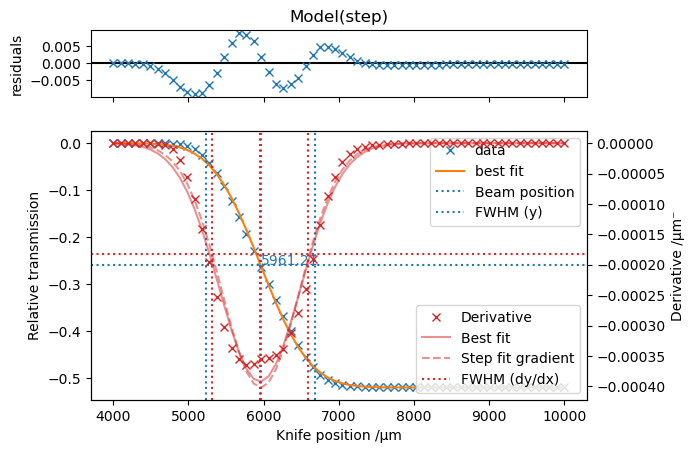

In [9]:
# Uncomment this line to manually specify a UID
# uid = ["927fa7dd-e331-45ca-bb9d-3f89d7c65b17"]
# Load the data for the first (and only) UID in the list
data = haven.load_data(uid[0])
# Save the data to a CSV file, with tabs ("\t") instead of commas.
data.to_pandas().to_csv(f"knife_scan_example_{uid[0].split('-')[0]}.csv", sep='\t')
# Do the fitting
transmission = data["It_raw_counts"] / data["I0_raw_counts"]
properties = haven.fit_step(x=data["Focus V "], y=transmission, plot=True, plot_derivative=True)
print(properties)